<a href="https://colab.research.google.com/github/NaughtyYoda/Web-Log-Analysis/blob/main/Web_Log_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WEB LOG ANALYSIS

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from zipfile import ZipFile
#!pip install ip2geotools
from ip2geotools.databases.noncommercial import DbIpCity

# Load Web log files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_filename = '/content/drive/MyDrive/Colab Notebooks/Github/Web Log Analysis/HTWebLog_p1.zip'

with ZipFile(zip_filename, 'r') as f:
    # get individual file names in zip 
    log_filenames = f.namelist()
    # extract all files from zip
    f.extractall()

In [4]:
# first five log file names
log_filenames[:5]

['ex061101.log',
 'ex061102.log',
 'ex061103.log',
 'ex061104.log',
 'ex061105.log']

There are 120 log files in zip

In [5]:
# total number of log files in zip
len(log_filenames)

120

### Store data from all 120 files in a single dataframe

In [6]:
# emplty list to store data
data = []

# column names
ColumnNames=[
    'date','time','s_sitename','s_ip','cs_method','cs_uri_stem',
    'cs_uri_query','s_port','cs_username','c_ip','cs(User_Agent)',
    'cs(Referer)','sc_status','sc_substatus','sc_win32_status'
]

def load_data(fileName):
    """
    This function stores a file name in pandas dataframe.
    Takes a global variable ColumnNames.
    Also, it counts the number of times it is called.
    """
    df = pd.read_csv(
        fileName, 
        delim_whitespace=True, # the data in log files is separated by space
        header = None, # to specify that there is no header in log files
        names = ColumnNames, # pass the columns, extracted in previous code block
        encoding = 'ISO-8859-1', 
        skiprows=4,
        na_values = '-', # nan's are present as '-'
        low_memory=False
    ) 

    # remove rows which start with #
    df = df[~df['date'].str.startswith("#")]
    
    load_data.counter += 1
    return df

# load files
print('Loading files in dataframe...(subtle weird mainframe noises in the background)')
load_data.counter = 0
data = [load_data(name) for name in log_filenames]

# combine all log files in a single dataframe
df_ht = pd.concat(data, ignore_index=True)

# fix dtype
for i in [7, 12, 13, 14]: 
      df_ht.iloc[:, i] = df_ht.iloc[:, i].astype('float64') # fix data type
df_ht.iloc[:, 8] = df_ht.iloc[:, 8].astype('object') 

print(f'Done! Number of log files loaded: {load_data.counter}')

Loading files in dataframe...(subtle weird mainframe noises in the background)
Done! Number of log files loaded: 120


# Data Exploration

In [7]:
# first five rows in the dataset
df_ht.head()

,date,time,s_sitename,s_ip,cs_method,cs_uri_stem,cs_uri_query,s_port,cs_username,c_ip,cs(User_Agent),cs(Referer),sc_status,sc_substatus,sc_win32_status
0,2006-11-01,00:00:08,W3SVC1,127.0.0.1,GET,/Default.aspx,NaN,80.0,NaN,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,http://www.google.com/search?sourceid=navclien...,200.0,0.0,0.0
1,2006-11-01,00:00:08,W3SVC1,127.0.0.1,GET,/Tulip/home/en-us/home_index.aspx,NaN,80.0,NaN,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,NaN,200.0,0.0,0.0
2,2006-11-01,00:00:08,W3SVC1,127.0.0.1,GET,/Tulip/includes/js/CommonUtil.js,NaN,80.0,NaN,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,http://www.hotelTulip.com.hk/Tulip/home/en-us/...,200.0,0.0,0.0
3,2006-11-01,00:00:09,W3SVC1,127.0.0.1,GET,/Tulip/common/common_style.aspx,lang=en-us,80.0,NaN,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,http://www.hotelTulip.com.hk/Tulip/home/en-us/...,200.0,0.0,0.0
4,2006-11-01,00:00:09,W3SVC1,127.0.0.1,GET,/Tulip/common/en-us/images/top_img.jpg,NaN,80.0,NaN,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,http://www.hotelTulip.com.hk/Tulip/home/en-us/...,200.0,0.0,0.0


There are approx. 8.4 million observations in the dataset with 15 columns

In [8]:
df_ht.shape

(8438928, 15)

In [9]:
df_ht.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8438928 entries, 0 to 8438927
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             object 
 1   time             object 
 2   s_sitename       object 
 3   s_ip             object 
 4   cs_method        object 
 5   cs_uri_stem      object 
 6   cs_uri_query     object 
 7   s_port           float64
 8   cs_username      object 
 9   c_ip             object 
 10  cs(User_Agent)   object 
 11  cs(Referer)      object 
 12  sc_status        float64
 13  sc_substatus     float64
 14  sc_win32_status  float64
dtypes: float64(4), object(11)
memory usage: 965.8+ MB


### Missing values

In [10]:
# missing values in respective columns:
def missing_data(df):
    """
    This function checks the number of missing values and missing percentage in a pandas dataframe.
    """
    missing_count = df.isnull().sum()
    missing_perc = df.isnull().sum()/len(df)*100
    missing_count = missing_count[missing_count > 0].sort_values(ascending=False)
    missing_perc = missing_perc[missing_perc > 0].sort_values(ascending=False)
    missing_data = pd.concat([missing_count, missing_perc], axis=1)
    missing_data.columns = ['missing_count', 'missing_percentage %']
    return missing_data

missing_data(df_ht)

,missing_count,missing_percentage %
cs_username,8438928,100.000000
cs_uri_query,7886532,93.454192
cs(Referer),1308994,15.511378
cs(User_Agent),3527,0.041794


In [11]:
# drop columns with atleast 15% missing values
df_ht.dropna(axis=1, thresh=0.85*len(df_ht), inplace=True)

# percentage of missing values after removing
print('Pecentage of Missing Values after removing columns with 15% or more missing values:')
missing_data(df_ht)

Pecentage of Missing Values after removing columns with 15% or more missing values:


,missing_count,missing_percentage %
cs(User_Agent),3527,0.041794


In [12]:
# drop remaining rows with missing values
df_ht.dropna(axis=0, inplace=True)

In [13]:
# shape of data after removing NA's
df_ht.shape

(8435401, 12)

In [14]:
df_ht.head()

,date,time,s_sitename,s_ip,cs_method,cs_uri_stem,s_port,c_ip,cs(User_Agent),sc_status,sc_substatus,sc_win32_status
0,2006-11-01,00:00:08,W3SVC1,127.0.0.1,GET,/Default.aspx,80.0,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200.0,0.0,0.0
1,2006-11-01,00:00:08,W3SVC1,127.0.0.1,GET,/Tulip/home/en-us/home_index.aspx,80.0,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200.0,0.0,0.0
2,2006-11-01,00:00:08,W3SVC1,127.0.0.1,GET,/Tulip/includes/js/CommonUtil.js,80.0,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200.0,0.0,0.0
3,2006-11-01,00:00:09,W3SVC1,127.0.0.1,GET,/Tulip/common/common_style.aspx,80.0,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200.0,0.0,0.0
4,2006-11-01,00:00:09,W3SVC1,127.0.0.1,GET,/Tulip/common/en-us/images/top_img.jpg,80.0,70.80.84.76,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200.0,0.0,0.0


# Web Traffic Analysis

In [15]:
def get_hour(time_string):
    """ this function gets the hour of the day from time string"""
    # splits the string where ':' character
    tokens = time_string.split(':')
    # get the first token (hour) and change the data type to int
    hour_token = int(tokens[0])
    return hour_token

In [16]:
# example:
print(f"Original Time string - {df_ht['time'][4546]}")
print(f"After applying get_hour function on above time string - {get_hour(df_ht['time'][4546])}")

Original Time string - 02:13:17
After applying get_hour function on above time string - 2


In [17]:
# apply function on data frame attribute
hourly_request_amount = df_ht['time'].apply(get_hour).value_counts()
hourly_request_amount

9     553564
8     550744
3     546655
6     544734
4     529352
7     522365
14    493695
5     487330
15    473057
10    443519
13    442429
2     432290
16    387291
11    368948
12    367635
1     344334
17    250285
18    159546
0     155914
19     93829
23     83634
20     72559
21     66474
22     65218
Name: time, dtype: int64

### Hourly Requests

- The bar chart displays the hourly traffic on the server, throughout the day, for a period between 1st November 2006 to 1st March 2007.
- The x-axis represents the hour of the day (time-period) and y-axis represents the number of requests received in that respective time-period. 
- It can be observed that the traffic is high twice a day i.e., between 3 a.m. to 9 a.m. and 1 p.m. to 4 p.m. Finally, the traffic starts declining after evening.
- The distribution looks like a bimodal distribution.   

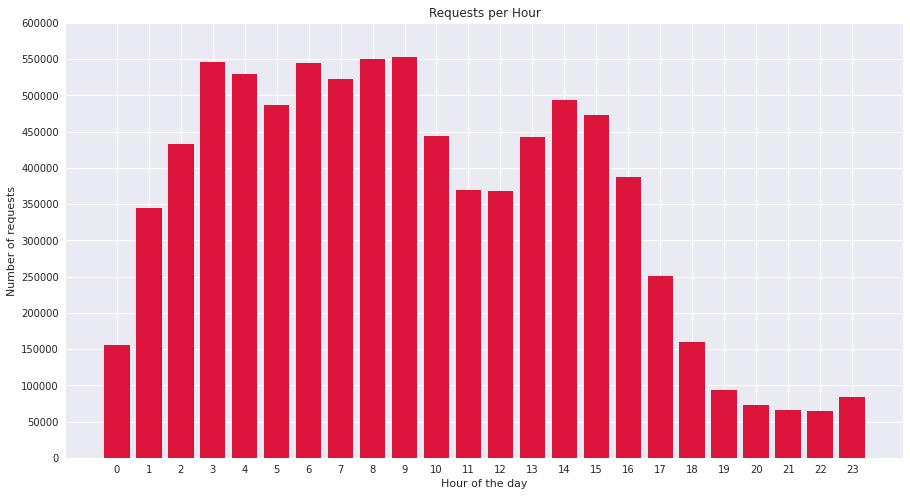

In [18]:
# bar chart
with plt.style.context('seaborn'):
    plt.figure(figsize=(15, 8))
    plt.bar(hourly_request_amount.index, hourly_request_amount.values, color='crimson')
    plt.xticks(hourly_request_amount.index.sort_values())
    plt.yticks(np.arange(0, 600_001, 50_000))
    plt.title("Requests per Hour")
    plt.ylabel('Number of requests')
    plt.xlabel('Hour of the day')

# Server Analysis

In [19]:
# types of reported status
status_counts = df_ht['sc_status'].value_counts()
print(status_counts.index.values)

[200. 304. 404. 206. 302. 500. 403. 301. 400. 501. 406. 416.]


In [20]:
status_counts

200.0    6072524
304.0    2136930
404.0     142583
206.0      72472
302.0       7366
500.0       2013
403.0        700
301.0        433
400.0        210
501.0        113
406.0         54
416.0          3
Name: sc_status, dtype: int64

In [21]:
# number of status
print(len(status_counts.index.values))

12


In [22]:
status_counts.index.astype('category')

CategoricalIndex([200.0, 304.0, 404.0, 206.0, 302.0, 500.0, 403.0, 301.0,
                  400.0, 501.0, 406.0, 416.0],
                 categories=[200.0, 206.0, 301.0, 302.0, 304.0, 400.0, 403.0, 404.0, ...], ordered=False, dtype='category')

### Reported Server Status
- The pie chart displays the percentage of number of times a type of server status was reported. 
- Server status type 200 was the most common server-status type reported during that time-period (approx. 72 percent of the time). 
- The second most common server-status reported was 304 (approx. 25 percent of time), followed by 404 (approx 2%).
- Rest of the server-status reported were quite rare (less than equal to 1 percent of the time). 

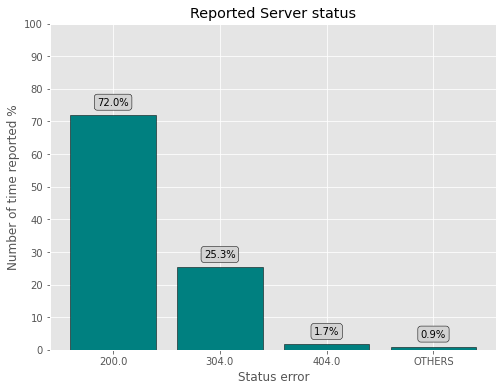

In [23]:
x = [str(val) for i, val in enumerate(status_counts.index) if i < 4]
x[3] = 'OTHERS'
y = [round(val/sum(status_counts.values)*100, 1) for i, val in enumerate(status_counts) if i < 4]
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 6))
    plt.bar(x, y, edgecolor='black', color='teal')
    for s, val in zip(x, y):
        plt.text(s, val+3, f"{val}%", ha='center', bbox=dict(boxstyle='round', fc='lightgray', ec='black'))
    plt.yticks(np.arange(0, 101, 10))
    plt.title("Reported Server status")
    plt.xlabel('Status error')
    plt.ylabel('Number of time reported %')

# Geographical Analysis
The ipgeotools package can be used to get country and city names from the I.P. address. Since, the data is huge, only records for a specific day i.e., January 1, 2007 are selected.

In [24]:
# create a combined date-time column and parse it using pandas datetime function
df_ht['date_time'] = pd.to_datetime((df_ht['date'] + ' ' + df_ht['time']))

# selected requests
selected_requests = df_ht[df_ht['date_time'].between('2007-01-01 20:00:00', 
                                                     '2007-01-01 20:59:59', 
                                                     inclusive=True)].reset_index(drop=True)

In [25]:
# number of requests raised in that period
len(selected_requests)

214

### Country 

In [26]:
# get country codes
selected_requests['country_code'] = selected_requests['c_ip'].apply(lambda x: DbIpCity.get(x).country)

In [27]:
# number of countries involved
len(selected_requests['country_code'].unique())

5

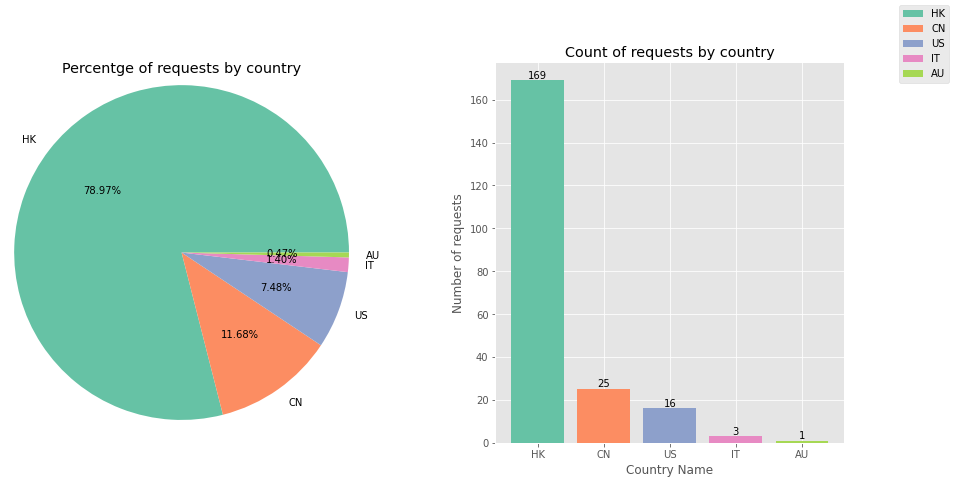

In [28]:
country_counts = selected_requests['country_code'].value_counts()
country_col = sns.color_palette("Set2")
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    plt.subplots_adjust(wspace=0.4)
    # plot 1: pie
    ax[0].pie(labels=country_counts.index, 
              x=country_counts.values, 
              colors=country_col, 
              autopct='%.2f%%', 
              radius=1.2)
    ax[0].set_title('Percentge of requests by country')
    # plot 2: bar
    ax[1].bar(country_counts.index, 
              country_counts.values, 
              color=country_col)
    for x, y in zip(country_counts.index, country_counts.values):
        ax[1].text(x, y+1, y, ha='center')
    ax[1].set_title('Count of requests by country')
    ax[1].set_xlabel('Country Name')
    ax[1].set_ylabel('Number of requests')
    fig.legend(country_counts.index)

### City

In [29]:
selected_requests['city'] = selected_requests['c_ip'].apply(lambda x: DbIpCity.get(x).city)

In [30]:
# number of cities involved
len(selected_requests['city'].unique())

11

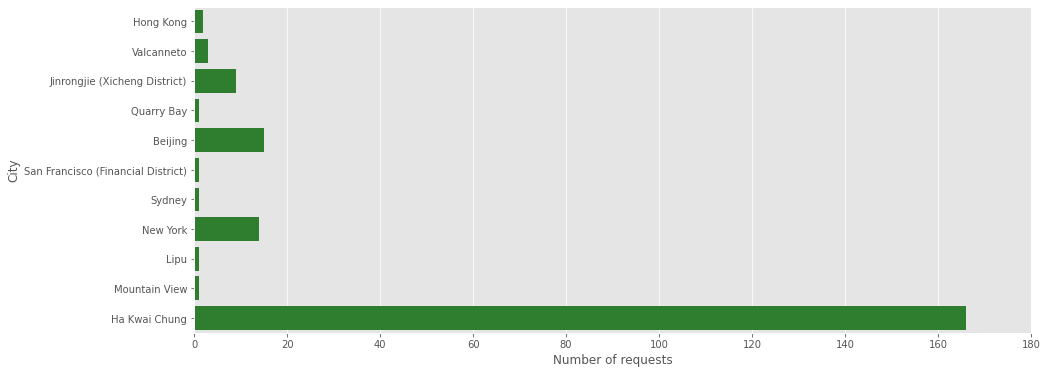

In [31]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(15, 6))
    sns.countplot(data=selected_requests, y='city', color='forestgreen')
    plt.ylabel('City')
    plt.xlabel('Number of requests')
    plt.xticks(np.arange(0, 181, 20))